## Arbol de Decisión para Clasificación

### Paso 1: Librerías

In [1]:
##Manipulación de la data
import numpy as np 
import pandas as pd 

##Graficar
import matplotlib.pyplot as plt 
import seaborn as sns 

##Evitar los warnings futuros
import warnings
warnings.filterwarnings('ignore')

##Librerías para test de normalidad
#import statsmodels.api as sm
from scipy import stats

##Librerias para preprocesamiento
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

##Librerías para over y under sampling
from sklearn.utils import resample

##Librería para train y test split
from sklearn.model_selection import train_test_split

##Librerías para graficar rendimiento del modelo sin balanceo
from sklearn.neighbors import KNeighborsClassifier
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.tree import DecisionTreeClassifier

### Funciones:


In [2]:
# Función para importar data .xlsx o .csv
def importDatos(ruta, archivo, ext, sep=None,encabe=None):
    if ext == '.csv':
        data = pd.read_csv(ruta+archivo+ext,sep=sep, header=encabe)
        return data
    elif ext == '.xlsx':
        data = pd.read_excel(ruta+archivo+ext)
        return data
    else:
        print('Extensión diferente')

# Función informe sobre los datos NAN


def datos_NA(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensiones : %d filas, %d columnas" %
              (df.shape[0], df.shape[1]))
        print("Total Valores NA : %d " % (total_na))
        print("%38s %10s     %10s %10s" %
              ("Nombre Columna", "Tipo de Dato", "#Distintos", "Valores NA"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" %
                  (col_name[i], dtyp[i], uniq[i], na_val[i]))

    else:
        print("Se esperaba dataframe %15s" % (type(df)))

# Función para pintar algo el histograma reemplazamos con la media o mediana


def histoPlot(df, nomCol, anchoBar):
    sns.histplot(data=df, x=nomCol, binwidth=anchoBar, kde=True)

# Función para reemplazo de valore numéricos con la mediana


def imputacionNa(df, nomCol, param):
    if param == 'media':
        df[nomCol] = df[nomCol].fillna(df[nomCol].mean())
        return df[nomCol]
    else:
        df[nomCol] = df[nomCol].fillna(df[nomCol].median())
        return df[nomCol]
# Funcion para revisar datos categóricos o texto


def revCategoricos(df, nomCol):
    rev = df[nomCol].value_counts()
    return rev

# Función para datos categóricos modificaciones


def imputacionCat(df, nomCol, busqueda, reempl):
    df[nomCol] = np.where(df[nomCol] == busqueda, reempl, df[nomCol])
    return df[nomCol]

# Función para reeemplazo NA categóricos


def imputacionCatNa(df, nomCol):
    df[nomCol] = df[nomCol].fillna(df[nomCol].mode()[0])
    return df[nomCol]

# Función para cambiar datos de texto a numerico float64


def cambioTextNum(df, nomCol, tipo):
    df[nomCol] = df[nomCol].astype(tipo)
    return df[nomCol]

# Función modificar a 1 y 0 los datos categóricos


def camTextBi(df, nomCol, busqueda, camuno, camdos):
    df[nomCol] = np.where(df[nomCol] == busqueda, camuno, camdos)
    return df[nomCol]

# Función para variables dummies


def convDummies(df, nomCol):
    dummies = pd.get_dummies(df[nomCol])
    data = pd.concat([df, dummies], axis=1)
    data.drop(columns=[nomCol], inplace=True)
    return data

# Función cambiar encabezados del dataframe


def camEncab(df, listaN):
    df.columns = listaN
    return df

# Función para el test de Shapiro - wilk - resistente al ruido en los datos


def testShapiroWilk(df):
    valoresP = []
    concepto = []
    variable = []
    for column in df:
        k2, p_value = stats.shapiro(df[column].values)
        valoresP.append(p_value)
        variable.append(column)
        if (p_value < 0.05):
            concepto.append('No es una variable Normal')
        else:
            concepto.append('Es una variable Normal')
    dfShapiro = pd.DataFrame(
        {'Variable': variable, 'Valores P': valoresP, 'Concepto': concepto})
    return dfShapiro

# Función para normalizar la data min - max sklearn


def normaData(df):
    valores = df.values  
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(valores)

    pd.DataFrame(np.vstack((scaler.data_min_, scaler.data_max_)),
             index=['Min', 'Max'],
             columns=df.columns)

    normalizados = scaler.transform(valores)
    df_norm = pd.DataFrame(normalizados,
                       index=df.index,
                       columns=df.columns)
    return df_norm

## Función para hacer la matriz de correlación de manera Tidy
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy.
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

##Función de label encoder
def Codificacion(df, nomCol):
    label_e = LabelEncoder()
    df[nomCol] = label_e.fit_transform(df[nomCol])
    return df[nomCol]


##Función para correlaciones
def grafCor(matriz):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    sns.heatmap(
        matriz,
        annot     = True,
        cbar      = True,
        annot_kws = {"size": 10},
        vmin      = -1,
        vmax      = 1,
        center    = 0,
        cmap      = sns.light_palette("#0d47a1"),
        square    = True,
        ax        = ax,
        linewidth=.5
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation = 45,
        horizontalalignment = 'right',
    )

    ax.tick_params(labelsize = 10)

##Función para revisión de frecuencias absolutas
def revCategoA(df):
    for i in df.columns:
        #print(round(df[i].value_counts()/np.float64(len(df)),3))
        print(df[i].value_counts())

##Función para particionar la data con base en los nombres de encabezados
def partEnc(df, nomVar):
    listaCol = []
    for i in df.columns:
        if i !=nomVar:
            listaCol.append(i)
    return listaCol

###Función para graficar el desbalanceo en la variable predictora
def grafDes(varytrain, nomx, nomy, titulo):
    conteo = varytrain.value_counts()
    conteo.plot.bar()
    plt.ylabel(nomy)
    plt.xlabel(nomx)
    plt.title(titulo)
    plt.show()

##Función para graficar modelos en su precisión y recall
def grafModelos(xtrain, ytrain, xtest, ytest):
    modelo = DecisionTreeClassifier()

    modelo.fit(xtrain, ytrain)
    
    y_score= modelo.predict_proba(xtest)

    y_pred = modelo.predict(xtest)

    plot_roc(ytest, y_score)
    plt.show()

    plot_precision_recall(ytest, y_score)
    plt.show()


### Paso 1: Importación

In [3]:
datos = importDatos('./Datasets/','car_evaluation','.csv')
datos.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
##Cambios de encabezado
datos = camEncab(datos, ['Vcompra','Mante','CantPuertas','CantPer','CapacBaul','Seguridad','Clase'])

datos.head()

,Vcompra,Mante,CantPuertas,CantPer,CapacBaul,Seguridad,Clase
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
revCategoA(datos)

vhigh    432
high     432
med      432
low      432
Name: Vcompra, dtype: int64
vhigh    432
high     432
med      432
low      432
Name: Mante, dtype: int64
2        432
3        432
4        432
5more    432
Name: CantPuertas, dtype: int64
2       576
4       576
more    576
Name: CantPer, dtype: int64
small    576
med      576
big      576
Name: CapacBaul, dtype: int64
low     576
med     576
high    576
Name: Seguridad, dtype: int64
unacc    1210
acc       384
good       69
vgood      65
Name: Clase, dtype: int64


In [6]:
##revisar datos NAN
datos_NA(datos)

Dimensiones : 1728 filas, 7 columnas
Total Valores NA : 0 
                        Nombre Columna Tipo de Dato     #Distintos Valores NA
                               Vcompra     object            4          0
                                 Mante     object            4          0
                           CantPuertas     object            4          0
                               CantPer     object            3          0
                             CapacBaul     object            3          0
                             Seguridad     object            3          0
                                 Clase     object            4          0


In [7]:
## Revisar la categoría para clasificar
revCategoricos(datos, 'Clase')

unacc    1210
acc       384
good       69
vgood      65
Name: Clase, dtype: int64

### Paso 2: Limpieza y balanceo del dataframe

In [8]:
datos.Vcompra = Codificacion(datos, 'Vcompra')
datos.Mante = Codificacion(datos, 'Mante')
datos.CantPuertas = Codificacion(datos, 'CantPuertas')
datos.CantPer = Codificacion(datos, 'CantPer')
datos.CapacBaul = Codificacion(datos, 'CapacBaul')
datos.Seguridad = Codificacion(datos, 'Seguridad')

In [9]:
##Particionar la data X & y y graficar del desbalanceo de la variable Clase - Clasificar (Imbalanced Clasification)
X = datos[partEnc(datos,'Clase')]
y = datos['Clase']



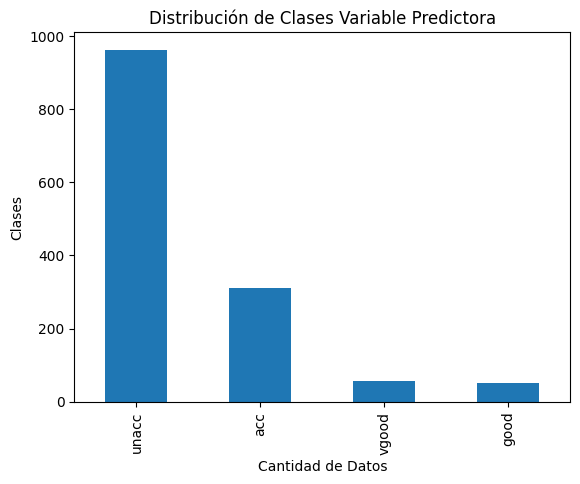

In [10]:
##Particion de la data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

grafDes(y_train, 'Cantidad de Datos','Clases','Distribución de Clases Variable Predictora')

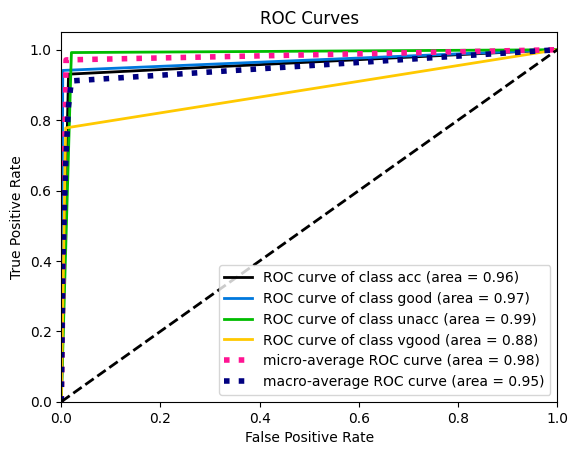

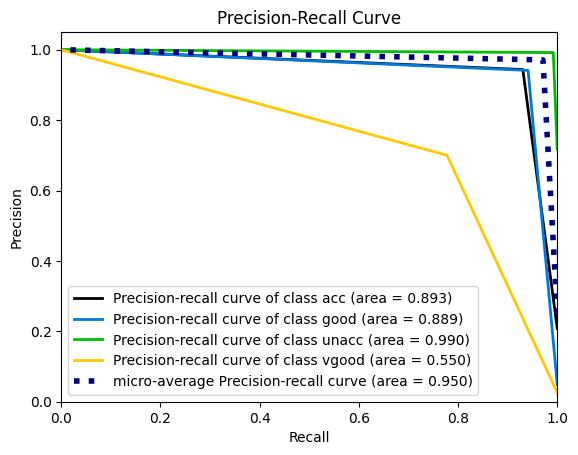

In [11]:
###Revisión de precisión y recall de las clases sin balancear

grafModelos(X_train, y_train, X_test, y_test)


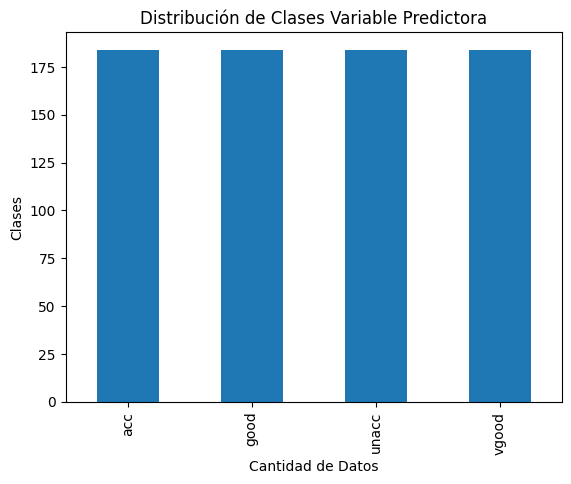

In [12]:
###Nivelación SMOTE - imblearn
conteo = y_train.value_counts()

n_samples = conteo.median().astype(np.int64)

def sampling_strategy(X,y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

from imblearn.under_sampling import ClusterCentroids

under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_train,y_train,n_samples,t='majority'))
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

from imblearn.over_sampling import SMOTE

over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under,n_samples, t='minority'),k_neighbors=2)
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

grafDes(y_bal, 'Cantidad de Datos','Clases','Distribución de Clases Variable Predictora')


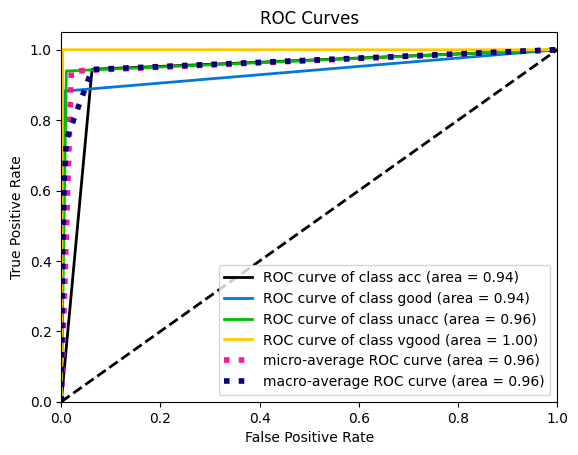

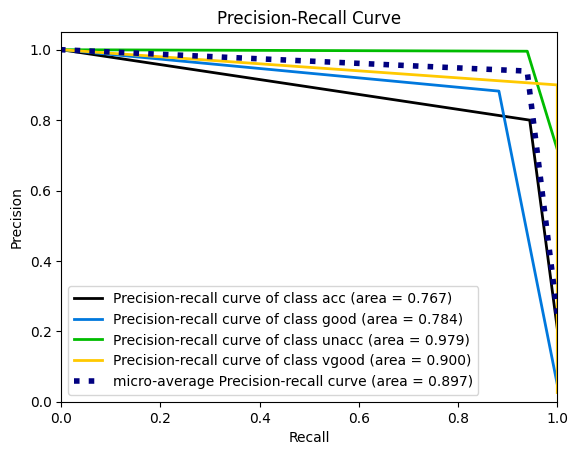

In [13]:
grafModelos(X_bal, y_bal, X_test, y_test)

In [14]:
##test de shapiro / Normalizar
dataNorm = normaData(X_bal)

testShapiroWilk(dataNorm)

,Variable,Valores P,Concepto
0,Vcompra,3.260722e-24,No es una variable Normal
1,Mante,1.664369e-24,No es una variable Normal
2,CantPuertas,5.611532e-25,No es una variable Normal
3,CantPer,6.652644e-30,No es una variable Normal
4,CapacBaul,2.483907e-31,No es una variable Normal
5,Seguridad,3.805631e-35,No es una variable Normal


In [15]:
testShapiroWilk(X_bal)

,Variable,Valores P,Concepto
0,Vcompra,3.260722e-24,No es una variable Normal
1,Mante,1.664369e-24,No es una variable Normal
2,CantPuertas,5.611532e-25,No es una variable Normal
3,CantPer,6.652644e-30,No es una variable Normal
4,CapacBaul,2.483907e-31,No es una variable Normal
5,Seguridad,3.805631e-35,No es una variable Normal


In [16]:
## Correlaciones
corr_matrix = X_bal.corr(method='pearson')

tidy_corr_matrix(corr_matrix)

,variable_1,variable_2,r,abs_r
15,CantPuertas,CantPer,0.147549,0.147549
20,CantPer,CantPuertas,0.147549,0.147549
34,Seguridad,CapacBaul,-0.131501,0.131501
29,CapacBaul,Seguridad,-0.131501,0.131501
27,CapacBaul,CantPer,-0.069462,0.069462
22,CantPer,CapacBaul,-0.069462,0.069462
18,CantPer,Vcompra,0.065041,0.065041
3,Vcompra,CantPer,0.065041,0.065041
4,Vcompra,CapacBaul,-0.045697,0.045697
24,CapacBaul,Vcompra,-0.045697,0.045697


Text(0.5, 1.0, 'Mapa de correlación')

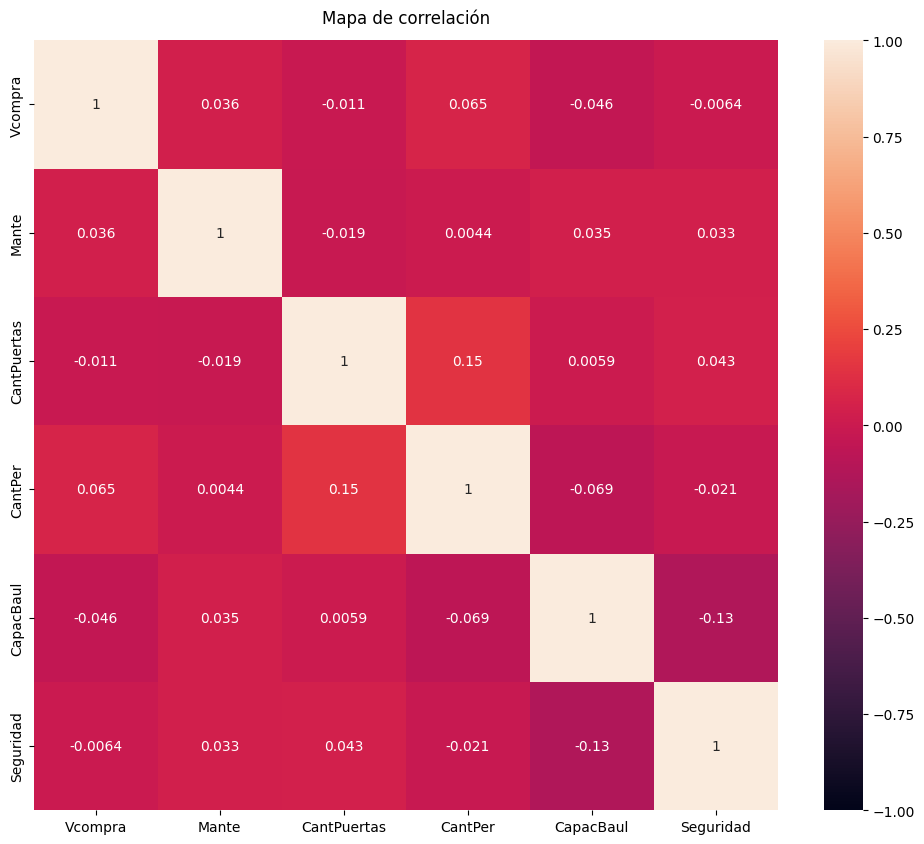

In [17]:
plt.figure(figsize=(12,10))

heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Mapa de correlación', fontdict={'fontsize':12}, pad=12)

In [18]:
##Creción del modelo - GINI
from sklearn.metrics import accuracy_score

modelogini = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=150)
modelogini.fit(X_train, y_train)
y_pred_gini = modelogini.predict(X_test)

print('La eficiencia general del modelo con datos testing es: {0:0.2f}'.format(accuracy_score(y_test, y_pred_gini)))

La eficiencia general del modelo con datos testing es: 0.94


In [19]:
y_pred_train_gini = modelogini.predict(X_train)

print('La eficiencia general del modelo con datos train es: {0:0.2f}'.format(accuracy_score(y_train, y_pred_train_gini)))

La eficiencia general del modelo con datos train es: 0.95


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_gini))

              precision    recall  f1-score   support

         acc       0.88      0.83      0.86        72
        good       0.70      0.82      0.76        17
       unacc       0.98      0.98      0.98       248
       vgood       0.75      1.00      0.86         9

    accuracy                           0.94       346
   macro avg       0.83      0.91      0.86       346
weighted avg       0.94      0.94      0.94       346



In [21]:
print(classification_report(y_train, y_pred_train_gini))

              precision    recall  f1-score   support

         acc       0.91      0.90      0.91       312
        good       0.65      0.75      0.70        52
       unacc       0.99      0.97      0.98       962
       vgood       0.82      1.00      0.90        56

    accuracy                           0.95      1382
   macro avg       0.84      0.91      0.87      1382
weighted avg       0.95      0.95      0.95      1382



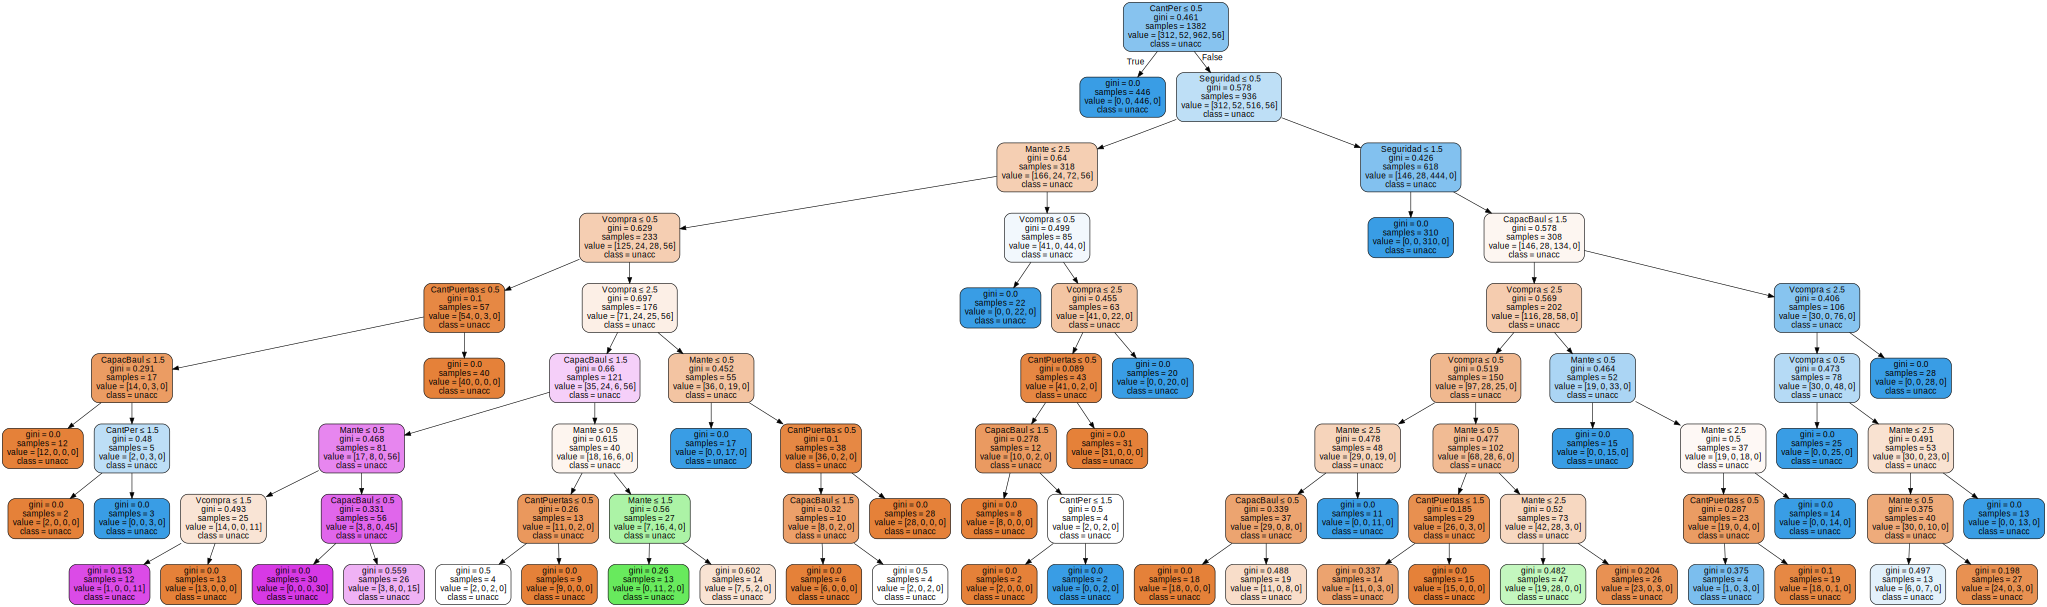

In [22]:
import graphviz

from sklearn import tree

data = tree.export_graphviz(modelogini, out_file=None,
        feature_names=X_train.columns,
        class_names=y_train,
        filled=True, rounded=True,
        special_characters=True)

grafica = graphviz.Source(data)

grafica

In [23]:
##Creción del modelo - Entropía
modeloentropy = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=150)
modeloentropy.fit(X_train, y_train)
y_pred_entropy = modeloentropy.predict(X_test)

print('La eficiencia general del modelo entropia con datos testing es: {0:0.2f}'.format(accuracy_score(y_test, y_pred_entropy)))

La eficiencia general del modelo entropia con datos testing es: 0.95


In [24]:
y_pred_train_entropy = modeloentropy.predict(X_train)

print('La eficiencia general del modelo entropia con datos train es: {0:0.2f}'.format(accuracy_score(y_train, y_pred_train_entropy)))

La eficiencia general del modelo entropia con datos train es: 0.95


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_entropy))

              precision    recall  f1-score   support

         acc       0.88      0.88      0.88        72
        good       0.70      0.82      0.76        17
       unacc       1.00      0.97      0.98       248
       vgood       0.75      1.00      0.86         9

    accuracy                           0.95       346
   macro avg       0.83      0.92      0.87       346
weighted avg       0.95      0.95      0.95       346



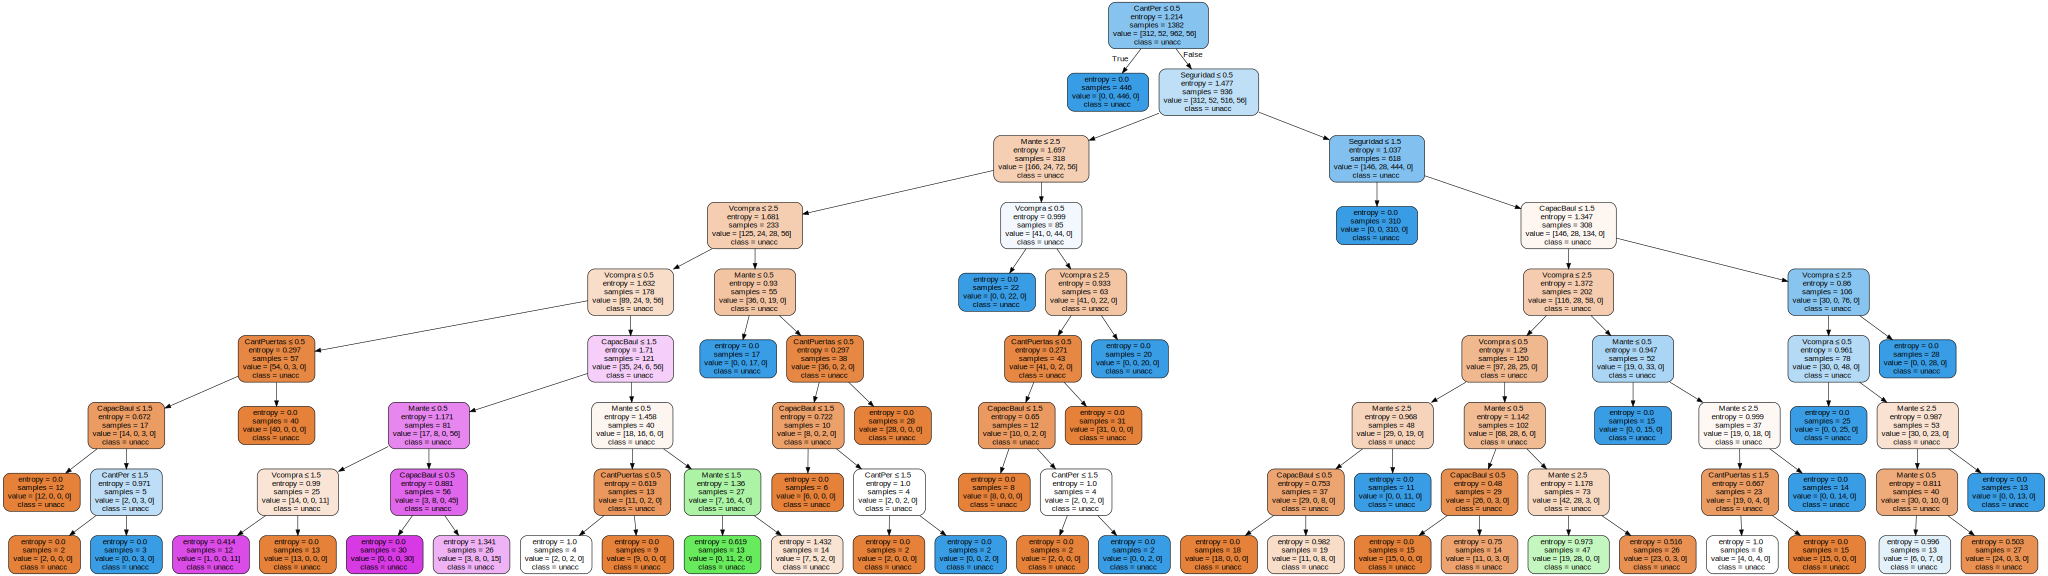

In [26]:
datados = tree.export_graphviz(modeloentropy, out_file=None,
        feature_names=X_train.columns,
        class_names=y_train,
        filled=True, rounded=True,
        special_characters=True)

graficados = graphviz.Source(datados)

graficados